# Forecasting Mini-Course Sales
**Playground Series - Season 3, Episode 19 - A Kaggle playground prediction competition**



[Forecasting Mini-Course Sales](https://www.kaggle.com/competitions/playground-series-s3e19)

A Kaggle competition where the goal is to predict a year worth of sales (for 2022) of fictional learning modules from fictional Kaggle branded stores in different countries. The provided dataset is synthetically generated, however, it is still modeled from real world data. As a result, it includes many realistic features that would reflect a production situation.

## Setup

Some warnings are intentionally suppressed, as they are harmless. This may change in the future.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Both the [Pre-Processing](#Pre-Processing) step and [The Models](#The-Models) require additional packages to be installed:
- [CatBoost](https://catboost.ai/), [LightGBM](https://github.com/microsoft/LightGBM) and [XGBoost](https://xgboost.readthedocs.io/en/stable/) are all gradient boosting machines that be used to construct the models.
- [category_encoders](https://contrib.scikit-learn.org/category_encoders/) will be used to transform ordinal variables in the [Pre-Processing](#Pre-Processing) pipeline in an efficient and simplified manner.
- [fastai](https://github.com/fastai) will be used for its `get-datepart` function, which will automatically generate a range of useful date features.
- [holidays](https://python-holidays.readthedocs.io/en/latest/?badge=latest) will be used to gather important dates for pre-processing.
- [pycountry](https://github.com/flyingcircusio/pycountry) will be used to automatically gather various country information for pre-processing.
- [seaborn](https://seaborn.pydata.org/) will be used for plotting the data.

In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    !pip -q install catboost category_encoders fastai holidays lightgbm pycountry xgboost seaborn

In [3]:
import holidays
import random
import pickle
import pycountry
import shutil
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from category_encoders import OrdinalEncoder
from fastai.tabular.core import add_datepart
from IPython.display import display, HTML
from lightgbm import LGBMRegressor
from pathlib import Path
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
from sklearn.pipeline import Pipeline, make_pipeline
from tqdm.auto import tqdm
from xgboost import XGBRegressor

## The Data

In [4]:
base_path = Path('./')
path = Path(base_path/'playground-series-s3e19/')

A [smoothed version of the dataset](https://www.kaggle.com/datasets/shivanimalhotra91/playground-s3e19-covid-data-smoothed) has been used. This is because there is a noticable drop in sales during COVID in 2020. This can be considered anomalous, and therefore would likely not represent a statistical trend over the 5 year period, and not helpful in making predictions for the following year. The difference between the original and smoothed datasets is illustrated in the [plots](#Plotting-the-Data) below:

In [5]:
smoothed_dataset_path = base_path/'playground-s3e19-covid-data-smoothed/course_sales (1).csv'
dataset_path = Path('train_smoothed.csv')
if (smoothed_dataset_path).is_file():
    if not dataset_path.is_file(): shutil.copy(smoothed_dataset_path, dataset_path)
else:
    print('Smoothed dataset does not exist. Please download it from: \
    https://www.kaggle.com/datasets/shivanimalhotra91/playground-s3e19-covid-data-smoothed \
         or via the Data menu on Kaggle.')

In [6]:
train_df_orig = pd.read_csv(path/'train.csv').drop('id', axis=1)
train_df = pd.read_csv(dataset_path).drop('id', axis=1)
test_df = pd.read_csv(path/'test.csv').drop('id', axis=1)

We will do some basic reformatting and pre-processing as it is more appropriate to do it here as opposed to the pipeline stage:
- Convert dates from `string`s into `datetime` objects.
- Convert the predicted sales (`num_sales`) for 2020 in the smoothed dataset from `float`s to `int`s, as we are predicting sales quantities for whole units only. We can get away with using a 16-bit integer, as the max units sold ranges from `0.0` to `1380.0`.

In [7]:
train_df_orig['date'] = pd.to_datetime(train_df_orig['date'], format = '%Y-%m-%d')
train_df['date'] = pd.to_datetime(train_df['date'], format = '%Y-%m-%d')
test_df['date'] = pd.to_datetime(test_df['date'], format = '%Y-%m-%d')
train_df['num_sold'] = train_df['num_sold'].round().astype(np.int16)

### Plotting the Data

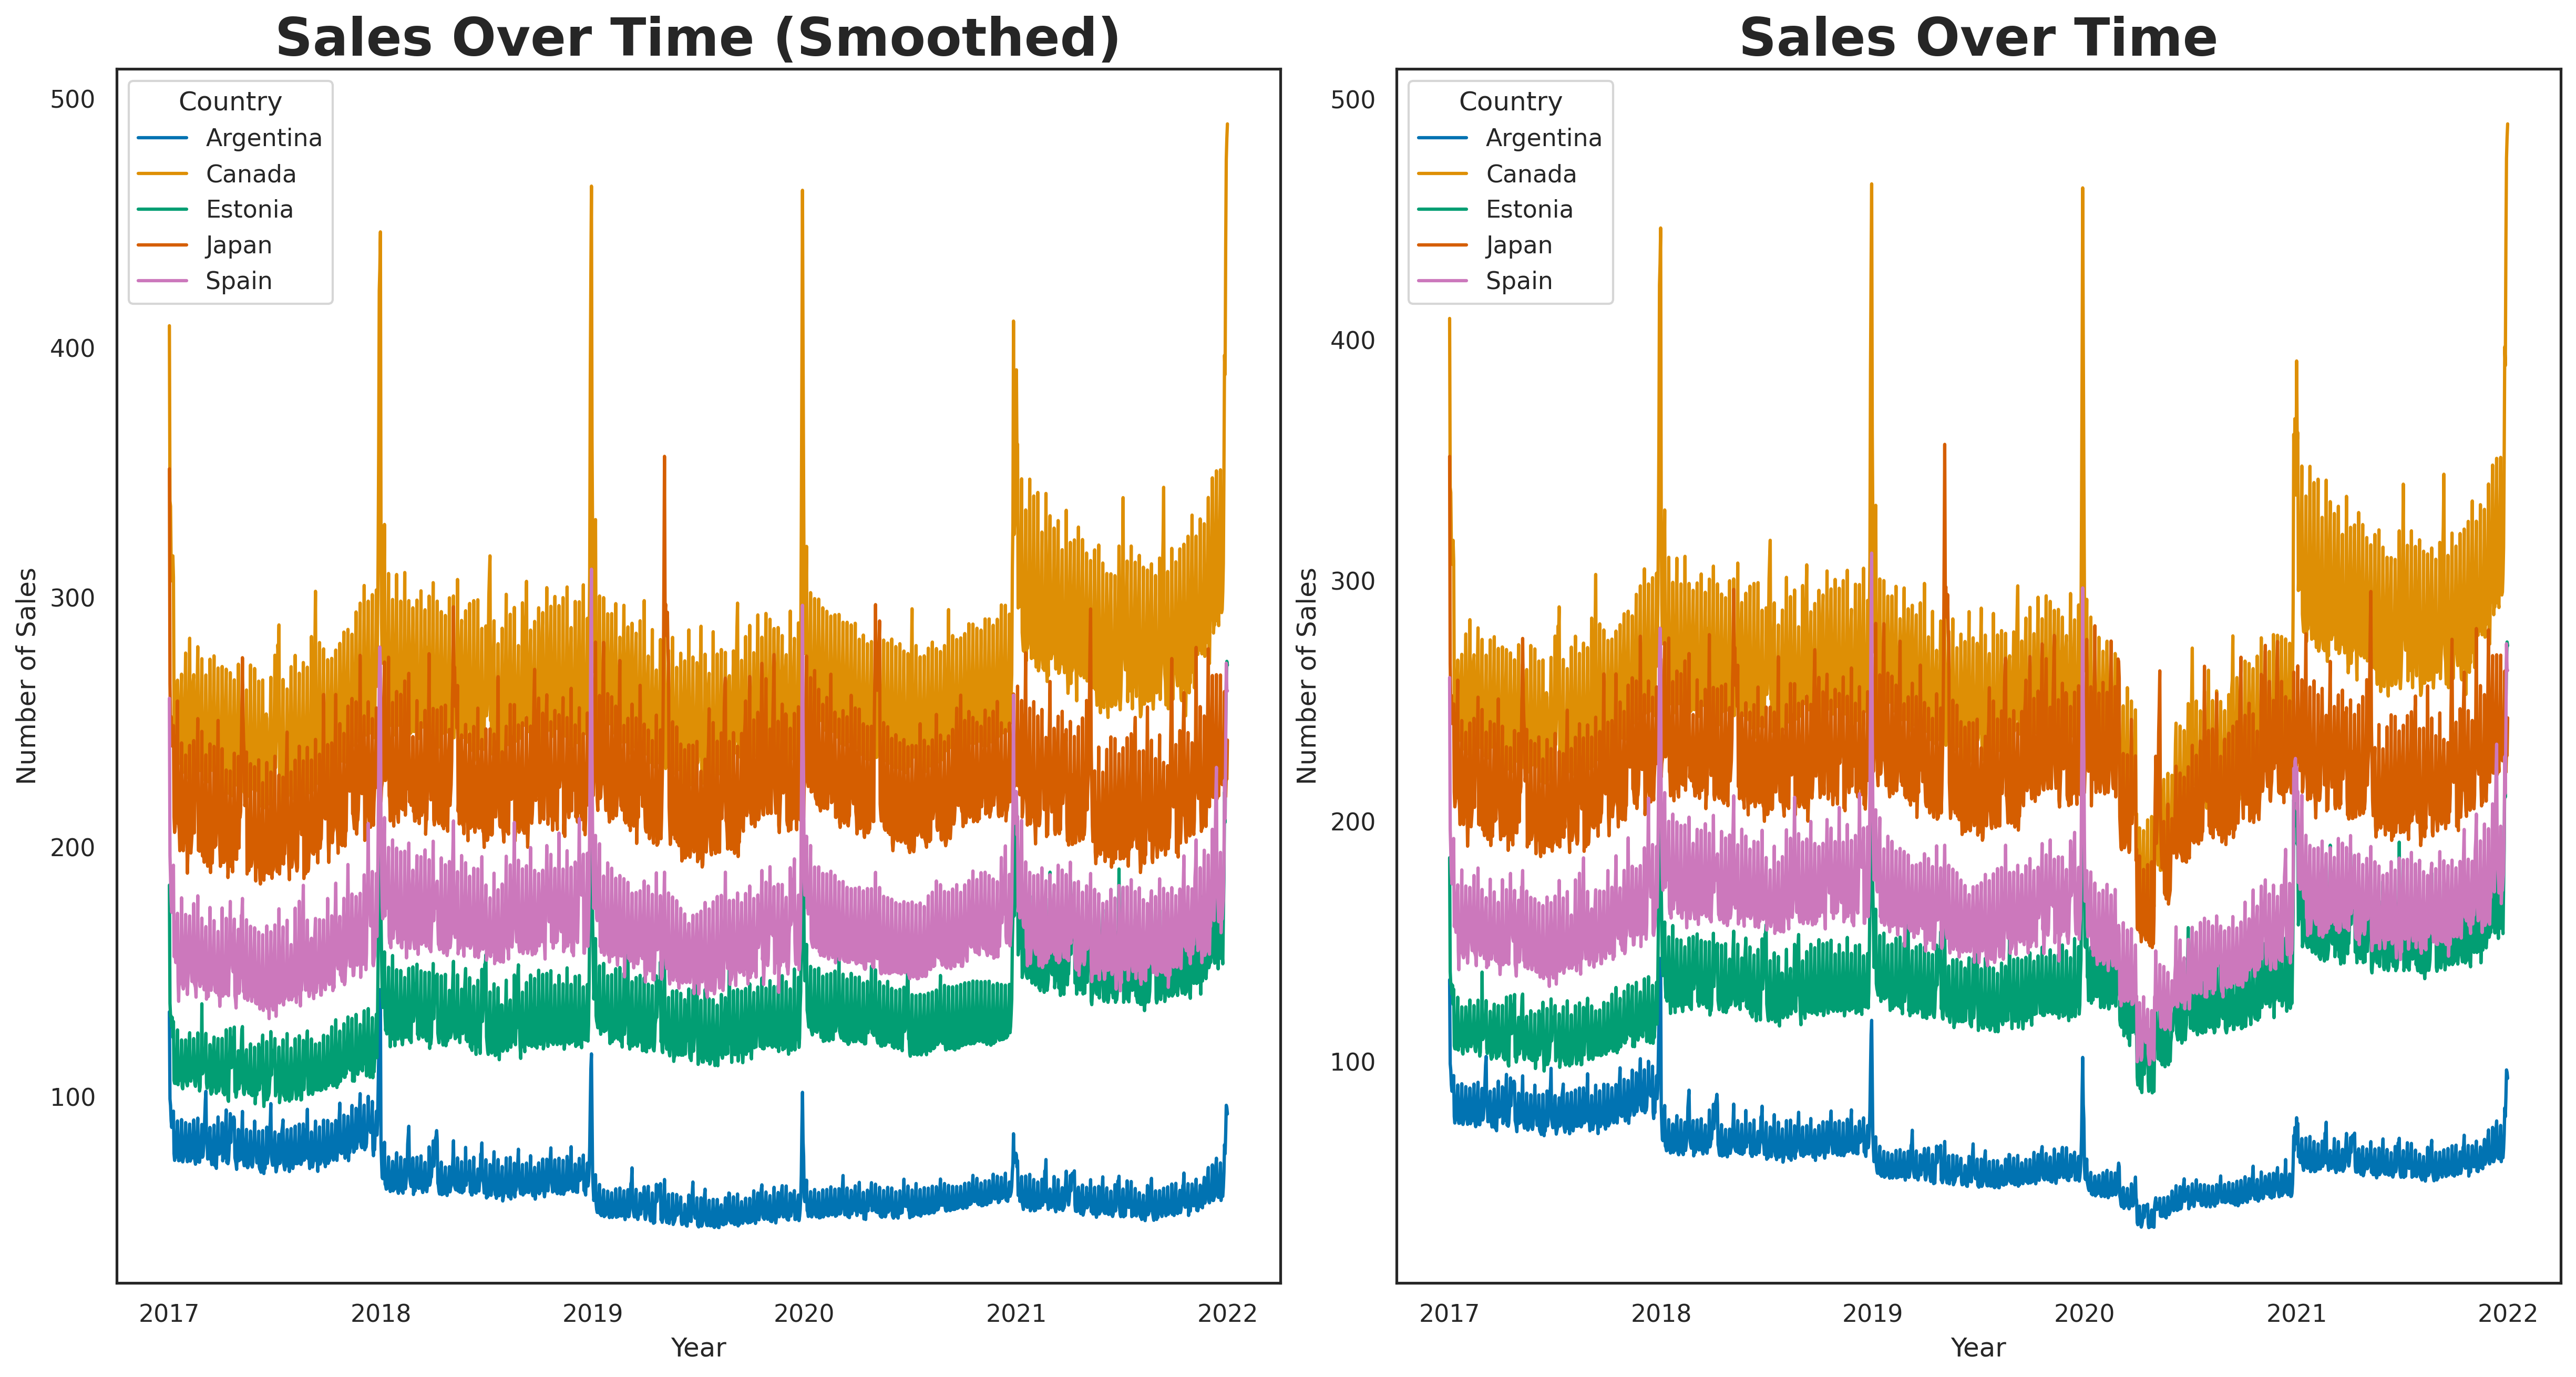

In [8]:
sns.set_theme(style='white', palette='colorblind')
fig, axes = plt.subplots(1, 2, figsize=(20, 10), dpi=300)
plt.subplots_adjust(wspace=0.1)

sns.lineplot(x=train_df.date, y=train_df.num_sold, hue=train_df.country, errorbar=None, ax=axes[0])
axes[0].set_title('Sales Over Time (Smoothed)', fontsize=24, fontweight='bold')
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Sales')
axes[0].legend(title='Country')

sns.lineplot(x=train_df_orig.date, y=train_df_orig.num_sold, hue=train_df_orig.country, errorbar=None, ax=axes[1])
axes[1].set_title('Sales Over Time', fontsize=24, fontweight='bold')
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Number of Sales')
axes[1].legend(title='Country')

plt.show()

### Exploring the Data

In [9]:
def get_desc_df(df):
    desc = pd.DataFrame(index=list(df))
    desc['count'] = df.count()
    desc['nunique'] = df.nunique()
    desc['%unique'] = desc['nunique'] / len(df) * 100.0
    desc['null'] = df.isnull().sum()
    desc['type'] = df.dtypes
    desc = pd.concat([desc, df.describe().T.drop('count', axis=1)], axis=1)
    return desc

In [10]:
train_desc = get_desc_df(train_df)
train_desc

,count,nunique,%unique,null,type,mean,min,25%,50%,75%,max,std
date,136950,1826,1.333333,0,datetime64[ns],2019-07-02 12:00:00,2017-01-01 00:00:00,2018-04-02 00:00:00,2019-07-02 12:00:00,2020-10-01 00:00:00,2021-12-31 00:00:00,NaN
country,136950,5,0.003651,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store,136950,3,0.002191,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product,136950,5,0.003651,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_sold,136950,1030,0.752099,0,int16,169.048974,3.0,47.0,100.0,185.0,1380.0,186.398916


In [11]:
test_desc = get_desc_df(test_df)
test_desc

,count,nunique,%unique,null,type,mean,min,25%,50%,75%,max
date,27375,365,1.333333,0,datetime64[ns],2022-07-02 00:00:00,2022-01-01 00:00:00,2022-04-02 00:00:00,2022-07-02 00:00:00,2022-10-01 00:00:00,2022-12-31 00:00:00
country,27375,5,0.018265,0,object,NaN,NaN,NaN,NaN,NaN,NaN
store,27375,3,0.010959,0,object,NaN,NaN,NaN,NaN,NaN,NaN
product,27375,5,0.018265,0,object,NaN,NaN,NaN,NaN,NaN,NaN


It seems there is nothing out of the ordinary in regards to the data. There are no harmful `NaN`s or `Null` values.

## Pre-Processing

First, we make a copy of the training dataset (`train_df`), as the original cannot be used. This is because the `add_datepart` function in the `DateProcessor` class performs modifications to the original `DataFrame` in-place. Additionally, the `ImportantDateProcessor` class needs the unmodifed dataset kept intact, as it still contains the `num_sold` column, which needs to be removed from the training copy (`X`). Then, a series of sklearn `Tranform`s are defined which will eventually be put into a `Pipeline`, for processing the data so that it has a useful set of features for the models to ingest.

In [12]:
X = train_df.copy()
y = X.pop('num_sold')

Seperate out the current categorical features from the numerical, then run the categorical features through an `OridinalEncoder`:

In [13]:
categorical_features = ['country', 'store', 'product']
numerical_features = test_df.drop(categorical_features, axis=1).columns

In [14]:
countries = sorted(X['country'].unique())
cat_vars = ['country', 'store', 'product', 'ImportantDate', 'seas_01',
            'seas_02', 'seas_03', 'seas_04'] + countries
ordinal_encoder = OrdinalEncoder(cols=cat_vars)

The `DateProcessor` class uses fastai's `add_datepart` function to add a seires of useful date features to the dataset. These include:
`Year`, `Month`, `Week`, `Day`, `Dayofweek`, `Dayofyear`, `Is_month_end`, `Is_month_start`, `Is_quarter_end`, `Is_quarter_start`, `Is_year_end` and `Is_year_start`.

In [15]:
class DateProcessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): 
        return self
    def transform(self, X, y=None):
        return add_datepart(X.copy(), 'date')

The `ImportantDateProcessor`class captures information about important dates by looking at how many units are sold for each day of the year and comparing them to a threshold value. This adds a feature so that [the models](#The-Models) can tell which days have significantly more sales in a quantifiable way.

In [16]:
class ImportantDateProcessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        imp_perc = round(365.0 * 0.2)
        sold_max = train_df['num_sold'].max()
        sold_thresh = round(sold_max - (sold_max * 0.2))
        imp_dates = X['Dayofyear'][train_df['num_sold'] > sold_thresh].value_counts().sort_values(ascending=False)[:imp_perc]
        self.important_dates = imp_dates
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy['ImportantDate'] = X_copy['Dayofyear'].isin(self.important_dates)
        return X_copy

The `SeasonProcessor` adds seasonal fourier features to the dataset. Since there are many different countries, and the concept of a season is nebulous at best, a number of cyclical features are added in a methodical manner. In theory, the models should 'lock-on' to these features when they correlate with any other 'natural' seasonal data presented to the model.

In [17]:
class SeasonProcessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): 
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy['month_sin'] = np.sin(2 * np.pi * X_copy.Month / 12)
        X_copy['month_cos'] = np.cos(2 * np.pi * X_copy.Month / 12)
        X_copy['day_sin'] = np.sin(2 * np.pi * X_copy.Day / 31)
        X_copy['day_cos'] = np.cos(2 * np.pi * X_copy.Day / 31)
        X_copy['seas_01'] = np.floor((np.sin(2 * np.pi * X_copy.Month / 4) * 0.5 + 0.5) * 4)
        X_copy['seas_02'] = np.floor((np.cos(2 * np.pi * X_copy.Month / 4) * 0.5 + 0.5) * 4)
        X_copy['seas_03'] = np.floor((np.sin(2 * np.pi * (X_copy.Month + np.pi) / 4) * 0.5 + 0.5) * 4)
        X_copy['seas_04'] = np.floor((np.cos(2 * np.pi * (X_copy.Month + np.pi) / 4) * 0.5 + 0.5) * 4)
        return X_copy

The `HolidaysProcessor` class gets a list of holidays for each country and enumerates them for the models. This is a useful feature, as sales can fluctuate wildly depending on the nature of the holiday.

In [18]:
class HolidaysProcessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): 
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        years = np.append(sorted(X_copy['Year'].unique()), X_copy['Year'].max() + 1)
        countries = sorted(X_copy['country'].unique().tolist())
    
        hols_dict = {}
        for c in countries:
            country_alpha2 = pycountry.countries.get(name=c).alpha_2
            for date, name in holidays.CountryHoliday(country_alpha2, years=years).items():
                hols_dict[pd.to_datetime(date)] = name
        hols_enum = {k: v for v, k in enumerate(set(hols_dict.values()), start=1)}
        
        X_copy['date'] = pd.to_datetime(X_copy[['Year', 'Month', 'Day']])
        
        def set_holiday(row):
            if row['date'] in hols_enum.keys():
                return hols_enum[row['date']]
            return 0
        
        for country in countries:
            mask = X_copy['country'] == country
            X_copy.loc[mask, country] = X_copy.loc[mask].apply(set_holiday, axis=1)
        X_copy[countries] = X_copy[countries].fillna(0, axis=1)
        X_copy = X_copy.drop('date', axis=1)
        return X_copy

## Evaluation Metric

The models are to be evaluated using [Symmetric mean absolute percentage error (SMAPE)](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error). This is a percentage measurement of the absolute error between the prediction and target sales values. The lower the score, the better.

SMAPE has a lower bound of 0% and an upper bound of 100%, unlike mean absolute percentage error (MAPE), which does not. This makes for a simple and useful method of determining a model's performance at a glance. There is a chance this evaluation metric could be problematic, as it does not allow for underflow / overflow of the percentage output. Therefore, if something goes drastically wrong with a model's predictions (especially if they are averaged), it may not be observed immediately. That being said, a sanity check of the predictions should always be performed either way. The formula is show below:

$$\frac{100\%}{n} \sum_{t=1}^{n} \frac{|A_t - F_t|}{(|A_t| + |F_t|)/2}$$

In [19]:
def smape(a, f):
    return 100.0 / len(a) * np.sum(2.0 * np.abs(f - a) / (np.abs(a) + np.abs(f)))

# Cross-Validation

Cross-Validation will be used to select the best version of each model using `4` folds with `TimeSeriesSplit`. This amounts to **one fold per year** in the training dataset. Note that a single seed is used from the beginning so that any random elements, such as the samples picked for each fold, are consistent and can be replicated thoughout. Each model is [evaluated](#Evaluation) according to it's SMAPE score, and a list of these scores is returned so that the best model can be picked afterwards.

In [20]:
seed = np.random.randint(random.randint(0, 2**32 - 1))
np.random.seed(seed)

In [21]:
k = TimeSeriesSplit(4)

In [22]:
def cross_val_score(model, cv=k, x=X, y=y):
    val_predictions = np.zeros((len(train_df)))
    train_scores, val_scores = [], []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]   
        model.fit(X_train, y_train)
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
        val_predictions[val_idx] += val_preds
        val_score = smape(y_val, val_preds)
        val_scores.append(val_score)
    return val_scores

# The Models

Multiple models are being used in this case. [The Gradient Boosting Machines (GBMs)](https://en.wikipedia.org/wiki/Gradient_boosting) to be used are [CatBoost](https://catboost.ai/), [LightGBM](https://github.com/microsoft/LightGBM) and [XGBoost](https://xgboost.readthedocs.io/en/stable/). Given the sensitivity of GBMs to hyperparameters, hyperparameter tuning will be employed to select the best performing model.

All models run on the CPU in this case, as the GPU versions of the GBMs require extra / conflicting dependencies or manual compilation to run on [Kaggle](https://www.kaggle.com/).

### CatBoost Regressors

In [23]:
catboost_models = {
    'model': CatBoostRegressor,
    'label': 'CatBoost Regressor',
    'param_grid': {
        'verbose': [0],
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.001, 0.01, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0]
    }
}

### LightGBM Regressors

In [24]:
lgbm_models = {
    'model': LGBMRegressor,
    'label': 'LightGBM Regressor',
    'param_grid': {
        'verbose': [-1],
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.001, 0.01, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0]
    }
}

### XGBoost Regressors

In [25]:
xgboost_models = {
    'model': XGBRegressor,
    'label': 'XGBoost Regressor',
    'param_grid': {
        'verbosity': [0],
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.001, 0.01, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0]
    }
}

## Generate Models

First, we will check if the best models have already been saved in `best_models.pkl`, if they have, then load them. (Note that a new random seed is generated each time, so results will vary slightly in the prediction stage.)

Otherwise, we will generate the models using a hyperparameter search as well as cross-validation. This should give a good range of models to work with, and hopefully the search will find some models that are a good fit.

In [26]:
force_gen = False
best_models = []
best_models_path = Path('best_models.pkl')
if best_models_path.is_file() and not force_gen:
    with open(best_models_path, 'rb') as f:
        best_models = pickle.load(f)
    total_models = len(best_models)
    for i, model in enumerate(best_models, start=1):
        model_class, model_label, params, score = model
        display(HTML(f'<div style="font-size: 12px;"><b>({model_label} {i}/{total_models})</b>, \
            Best Score: {score:.4f}</div>'))
else:
    if best_models_path.is_file(): best_models_path.unlink()
    models = [catboost_models, lgbm_models, xgboost_models]
    total_models = len(models)
    best_models = []
    
    for i, model in enumerate(models, start=1):
        best_score = float('+inf')
        scores = []
        param_grid = list(ParameterGrid(model['param_grid']))
        model_class = model['model']
        model_label = model['label']
        pbar = tqdm(param_grid, unit='model', desc=f'Tuning: {model_label} ({i}/{total_models})', leave=False)
        
        for params in pbar:
            model_instance = model_class(**params)
            pipeline = make_pipeline(DateProcessor(), ImportantDateProcessor(),
                                     SeasonProcessor(), HolidaysProcessor(), ordinal_encoder, model_instance)
            val_scores = cross_val_score(pipeline)
            score = min(val_scores)
            scores.append((model_class, model_label, params, score))
            
        scores.sort(key = lambda x: x[3])
        best_score = scores[0][3]
        best_models.append(scores[0])
        display(HTML(f'<div style="font-size: 12px;"><b>({model_label} {i}/{total_models})</b>, \
        Best Score: {best_score:.4f}</div>'))
        with open(best_models_path, 'wb') as f:
            pickle.dump(best_models, f)

Tuning: CatBoost Regressor (1/3):   0%|          | 0/81 [00:00<?, ?model/s]

Tuning: LightGBM Regressor (2/3):   0%|          | 0/81 [00:00<?, ?model/s]

Tuning: XGBoost Regressor (3/3):   0%|          | 0/81 [00:00<?, ?model/s]

## Getting Predictions

Now that the best performing models have been found, we can train and fit them. This will give us our sales predictions for each model.

In [27]:
preds_list = []
pbar = tqdm(best_models, leave=False, unit='model')
for data in pbar:
    model_class, model_label, params, score = data
    pbar.set_description(f'Inference ({model_label})')
    model_instance = model_class(**params)
    pipeline = make_pipeline(DateProcessor(), ImportantDateProcessor(),
                             SeasonProcessor(), HolidaysProcessor(), ordinal_encoder, model_instance)
    pipeline.fit(X, y);
    preds = pipeline.predict(test_df);
    preds_list.append(preds)

  0%|          | 0/3 [00:00<?, ?model/s]

## Post-Processing

- First, the predictions are ensembled from each model via stacking and taking the mean.
- The model cannot differentiate between countries when making predictions. Thus, we need to multiply each country's sales by thier respective GDP to get accurate predictions for each one. The multipliers for each country are derived from the code outlined in this [discussion](https://www.kaggle.com/competitions/playground-series-s3e19/discussion/423725) on [Kaggle](https://www.kaggle.com/).
- Next, the adjusted predictions are rounded to the nearest integer, as we are predicting the sales of whole items only, they are then converted to `int16` format, as this is the most efficent way of storing them in this case given they only range between approx `0` and `1380`.
- Finally, a sanity check is performed by looking at the raw data and plotting it.

In [28]:
def country_multipliers(predictors, prediction, canada=1.0, japan=1.0,
                        spain=1.0, estonia=1.0, argentina=1.0):
    prediction[predictors.country == 'Argentina'] *= argentina
    prediction[predictors.country == 'Canada'] *= canada
    prediction[predictors.country == 'Japan'] *= japan
    prediction[predictors.country == 'Spain'] *= spain
    prediction[predictors.country == 'Estonia'] *= estonia
    return prediction

In [29]:
preds = np.vstack(preds_list)
preds = np.mean(preds, axis=0)
preds = country_multipliers(test_df, preds * 1.50, 0.58, 0.76, 1.00, 1.08, 2.82)
preds = preds.round().astype(np.int16)

In [30]:
preds

array([ 166,  157,    7, ...,  187, 1010,  818], dtype=int16)

In [31]:
pred_df = test_df.copy()
pred_df['num_sold'] = preds
pred_df.to_csv('submission.csv', index=False)

In [32]:
pred_df

,date,country,store,product,num_sold
0,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,166
1,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,157
2,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,7
3,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,149
4,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,114
...,...,...,...,...,...
27370,2022-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,1098
27371,2022-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,1066
27372,2022-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,187
27373,2022-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,1010


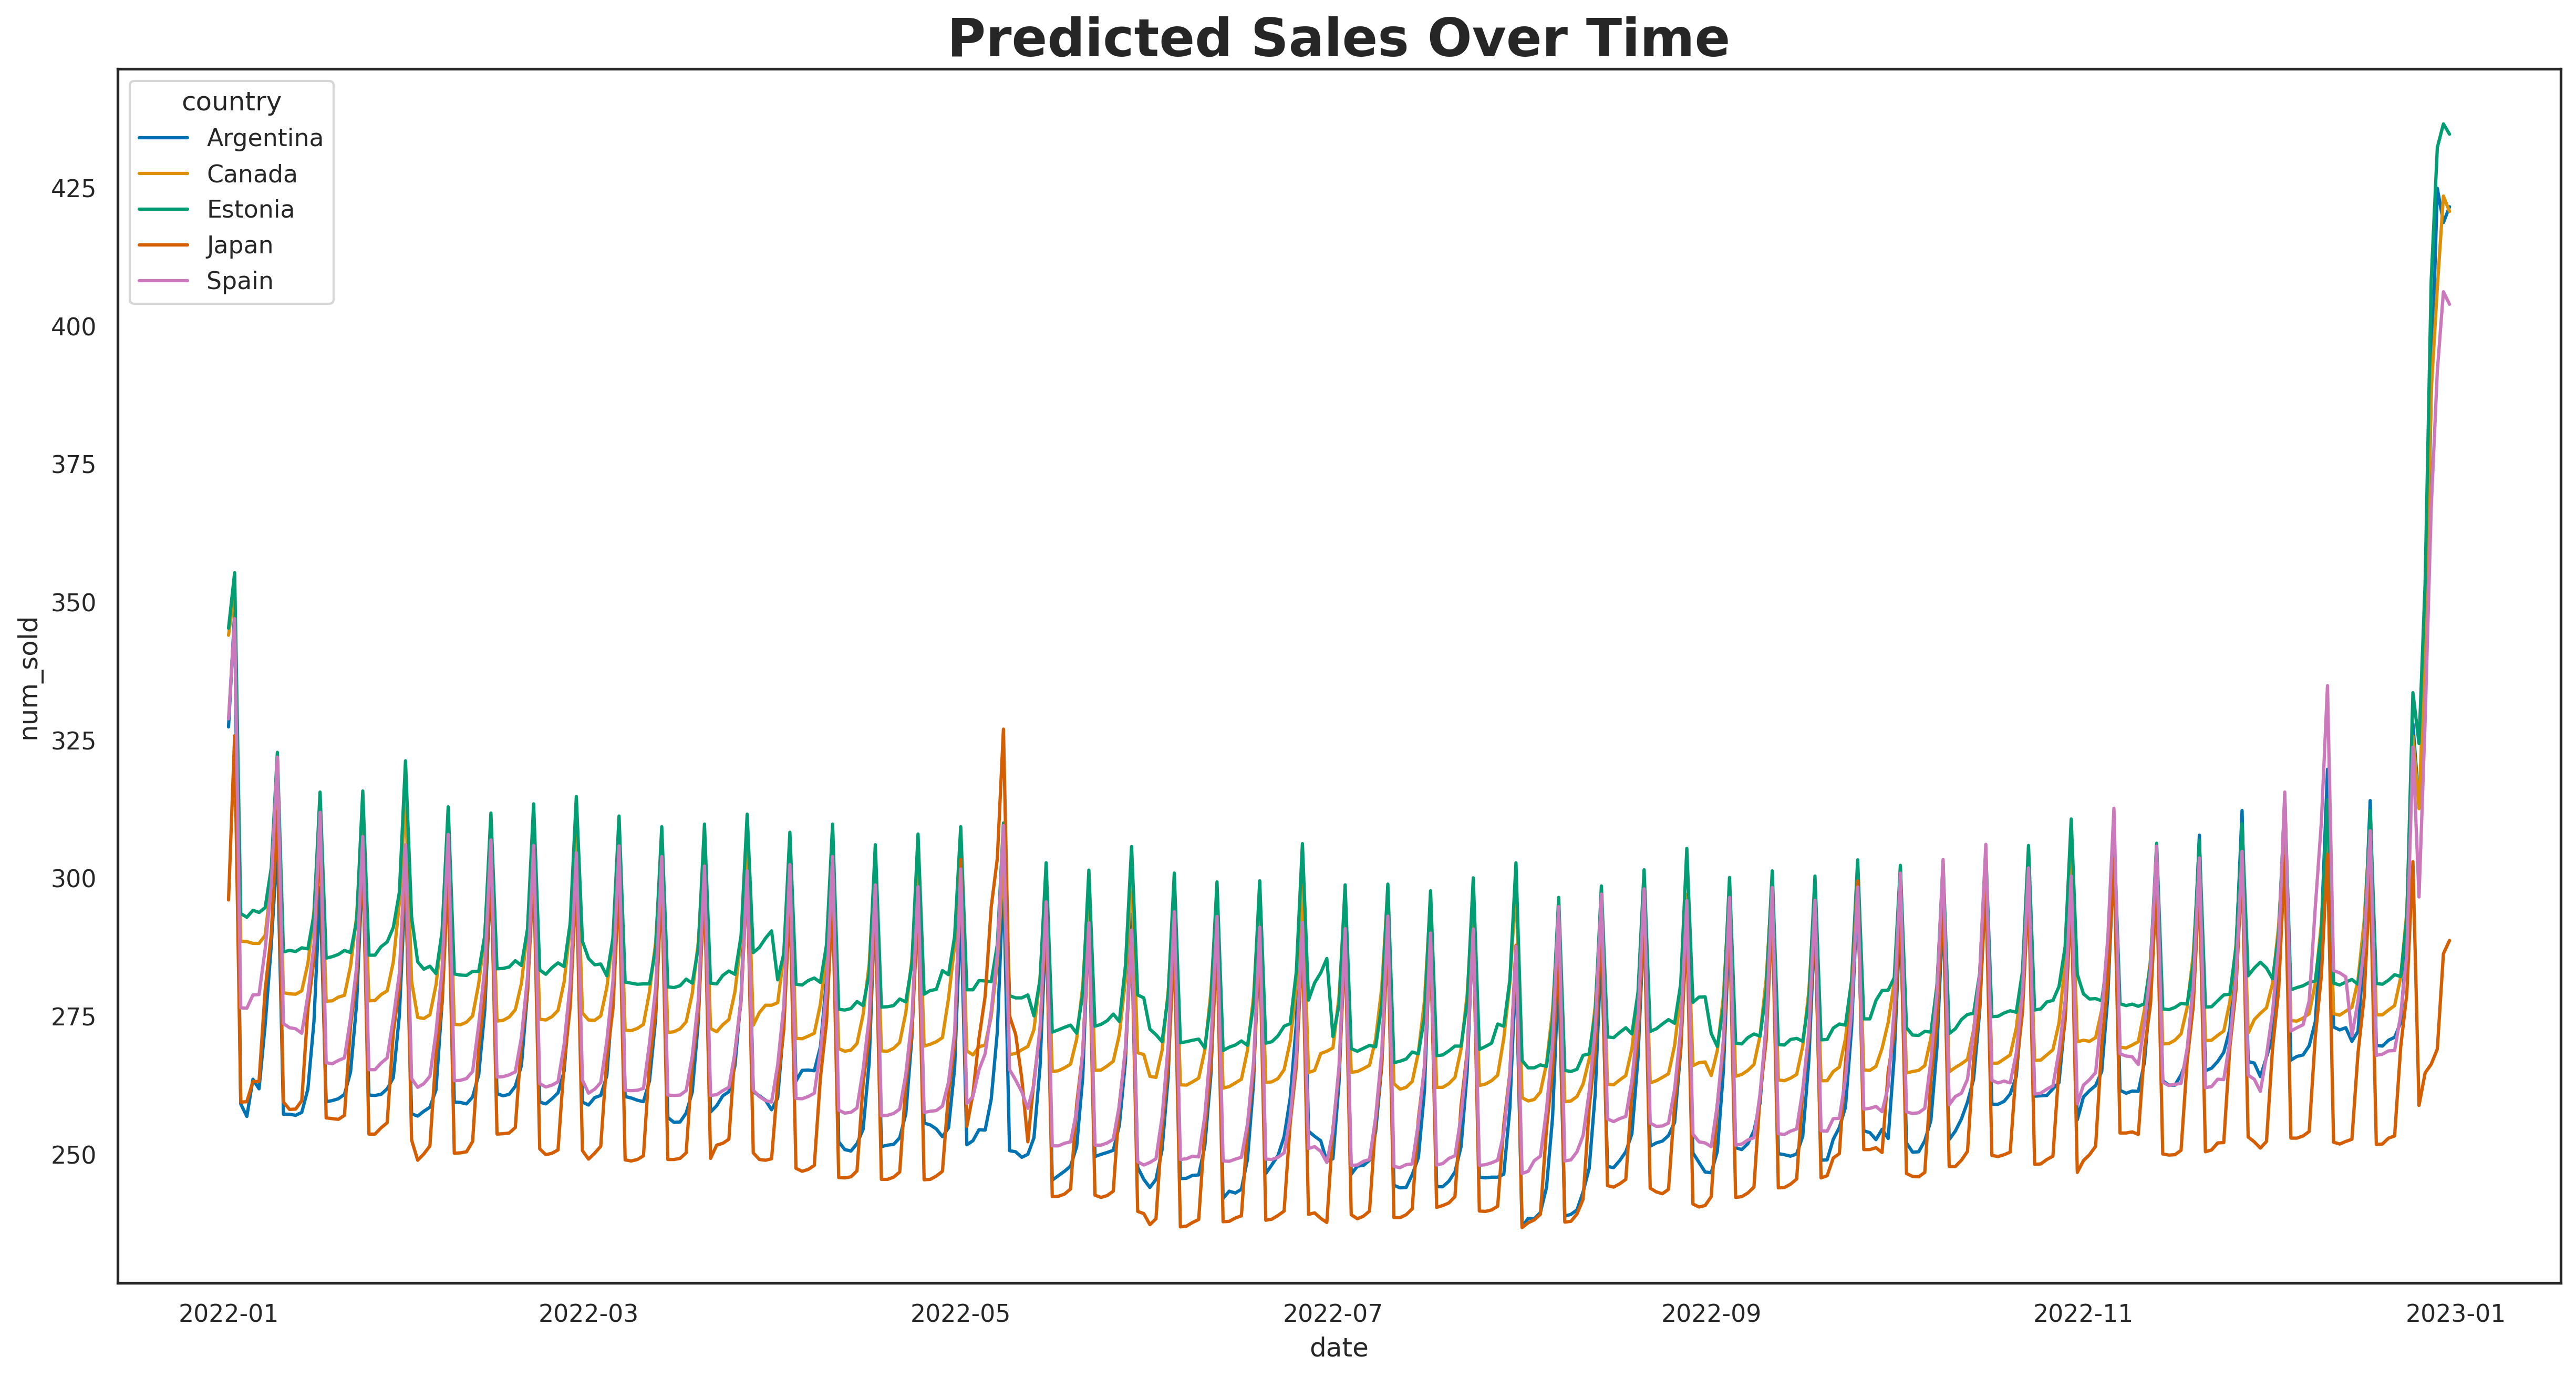

In [33]:
plt.figure(figsize=(20, 10), dpi=300)
sns.lineplot(x=pred_df.date, y=pred_df.num_sold, hue=pred_df.country, errorbar=None)
plt.title('Predicted Sales Over Time', fontsize=24, fontweight='bold')
plt.show()

It looks like these predictions are sane. The inflated values at the end of the plot are not an issue, as `seaborn` is taking a moving average to plot the values. Seeing as how the end of every year results in a huge amount of sales, this is not surprising and is weel within the realm of possibility.

## Submission

In [34]:
submit = False
if submit:
    from kaggle import api
    comp = 'playground-series-s3e19'
    api.competition_submit_cli(file_name='submission.csv', message='v1.0.5', competition=comp)